In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.linalg import expm
from scipy.integrate import odeint
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
import qiskit.quantum_info
import pandas as pd
import time

In [4]:
filename = r'C:\Users\LENOVO\OneDrive - Green University\Desktop\qrc for fokker plank\QRC-FPE\fpe_training_data.npy'
data_full = np.load(filename)
# Configuration
washout_len = 5
train_len = 25
n_inputs = 4
alpha_reg = 0.001

n_time_steps = data_full.shape[0]
test_len = n_time_steps - washout_len - train_len - 1

print(f"\nData Split Configuration:")
print(f"  Washout: {washout_len} steps")
print(f"  Train: {train_len} steps")
print(f"  Test: {test_len} steps")
print(f"  Total: {n_time_steps} steps\n")


Data Split Configuration:
  Washout: 5 steps
  Train: 25 steps
  Test: 20 steps
  Total: 51 steps



### Quantum Reservior Architectures

In [5]:
class QuantumReservoir:
    """Base class for quantum reservoirs"""
    
    def __init__(self, nqbits, n_inputs):
        self.nqbits = nqbits
        self.n_inputs = n_inputs
        self.U = None
        self.observables = self._build_observables()
        
    def _build_observables(self):
        """Build measurement operators (Z and X on each qubit)"""
        obs_list = []
        for i in range(self.nqbits):
            for p in ["Z", "X"]:
                label = ["I"] * self.nqbits
                label[i] = p
                obs_list.append(SparsePauliOp("".join(label)).to_matrix())
        return obs_list
    
    def encode_and_combine(self, features, rho_memory):
        """Encode features into quantum state using Ry rotations"""
        # Handle case where n_inputs > nqbits (use only first nqbits features)
        n_encode = min(self.n_inputs, self.nqbits)
        
        qc = QuantumCircuit(n_encode)
        for i in range(n_encode):
            qc.ry(features[i], i)
        psi = np.array(qiskit.quantum_info.Statevector(qc))
        rho_in = np.outer(psi, psi.conj())
        
        # If inputs fill the whole reservoir, no need to partial trace
        if n_encode == self.nqbits:
            return rho_in
            
        # Standard reservoir: partial trace and combine
        indices_to_trace = list(range(n_encode))
        rho_mem_reduced = qiskit.quantum_info.partial_trace(rho_memory, indices_to_trace).data
        return np.kron(rho_in, rho_mem_reduced)
    
    def measure(self, rho):
        """Measure expectation values of observables"""
        return np.array([np.trace(rho @ ob).real for ob in self.observables])
    
    def evolve(self, rho):
        """Evolve quantum state with unitary"""
        return self.U.conj().T @ rho @ self.U

In [6]:
class IsingReservoir(QuantumReservoir):
    """Ising Model Hamiltonian Reservoir (Friend's approach)"""
    
    def __init__(self, nqbits, n_inputs, J=0.5, h_factor=0.1, evolution_time=5.0, seed=42):
        super().__init__(nqbits, n_inputs)
        self.J = J
        self.h_factor = h_factor
        self.t = evolution_time
        self.seed = seed
        self.U = self._build_unitary()
        
    def _build_unitary(self):
        """Build Ising Hamiltonian with random couplings"""
        np.random.seed(self.seed)
        Js = np.random.uniform(-self.J/2, self.J/2, size=self.nqbits-1)
        h = self.J * self.h_factor
        
        pauli_list = []
        # ZZ couplings between adjacent qubits
        for i in range(self.nqbits - 1):
            label = ["I"] * self.nqbits
            label[i] = "Z"
            label[i+1] = "Z"
            pauli_list.append(("".join(label), Js[i]))
        
        # Transverse field (X terms)
        for i in range(self.nqbits):
            label = ["I"] * self.nqbits
            label[i] = "X"
            pauli_list.append(("".join(label), h))
        
        H_matrix = SparsePauliOp.from_list(pauli_list).to_matrix()
        return expm(-1j * H_matrix * self.t)

In [7]:
class RandomUnitaryReservoir(QuantumReservoir):
    """Random Haar-distributed Unitary Reservoir"""
    
    def __init__(self, nqbits, n_inputs, seed=42):
        super().__init__(nqbits, n_inputs)
        self.seed = seed
        self.U = self._build_unitary()
        
    def _build_unitary(self):
        """Generate random Haar-distributed unitary"""
        return qiskit.quantum_info.random_unitary(2**self.nqbits, seed=self.seed).data


class ParameterizedCircuitReservoir(QuantumReservoir):
    """Parameterized Quantum Circuit Reservoir"""
    
    def __init__(self, nqbits, n_inputs, n_layers=3, gate_set='universal', seed=42):
        super().__init__(nqbits, n_inputs)
        self.n_layers = n_layers
        self.gate_set = gate_set
        self.seed = seed
        self.U = self._build_unitary()
        
    def _build_unitary(self):
        """Build circuit with parameterized gates"""
        np.random.seed(self.seed)
        qc = QuantumCircuit(self.nqbits)
        
        for layer in range(self.n_layers):
            # Single-qubit rotations
            for i in range(self.nqbits):
                if self.gate_set == 'universal':
                    qc.rx(np.random.uniform(0, 2*np.pi), i)
                    qc.ry(np.random.uniform(0, 2*np.pi), i)
                    qc.rz(np.random.uniform(0, 2*np.pi), i)
                elif self.gate_set == 'simple':
                    qc.ry(np.random.uniform(0, 2*np.pi), i)
            
            # Entangling layer (CNOT gates)
            for i in range(self.nqbits - 1):
                qc.cx(i, i + 1)
        
        return qiskit.quantum_info.Operator(qc).data

In [8]:
class CustomMeasurementReservoir(IsingReservoir):
    """Ising reservoir with custom measurement strategies"""
    
    def __init__(self, nqbits, n_inputs, measurement_set='XZ', **kwargs):
        self.measurement_set = measurement_set
        super().__init__(nqbits, n_inputs, **kwargs)
        
    def _build_observables(self):
        """Build custom measurement operators"""
        obs_list = []
        paulis = list(self.measurement_set)
        
        for i in range(self.nqbits):
            for p in paulis:
                label = ["I"] * self.nqbits
                label[i] = p
                obs_list.append(SparsePauliOp("".join(label)).to_matrix())
        return obs_list

### QRC TRAINING AND TESTING

In [9]:
def train_qrc(reservoir, data_full, washout_len, train_len, n_inputs, alpha_reg):
    """
    Train QRC using friend's exact method:
    - PCA compression to n_inputs components
    - Scaling to [0, pi]
    - Washout phase
    - Training with Ridge regression
    """
    
    # PCA Compression
    pca = PCA(n_components=n_inputs)
    pca.fit(data_full[:washout_len + train_len])
    data_pca = pca.transform(data_full)
    
    # Scaling to [0, pi]
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    data_scaled = scaler.fit_transform(data_pca)
    
    # Training sets
    X_train_pca = data_scaled[washout_len : washout_len + train_len]
    Y_train_full = data_full[washout_len + 1 : washout_len + train_len + 1]
    
    # Initialize reservoir state
    rho = np.zeros((2**reservoir.nqbits, 2**reservoir.nqbits))
    rho[0, 0] = 1.0
    
    # Washout phase
    for t in range(washout_len):
        rho = reservoir.evolve(rho)
        rho = reservoir.encode_and_combine(data_scaled[t+1], rho)
    
    # Training phase - collect reservoir states
    X_res = []
    for t in range(train_len):
        rho = reservoir.evolve(rho)
        X_res.append(reservoir.measure(rho))
        if t < train_len - 1:
            rho = reservoir.encode_and_combine(X_train_pca[t+1], rho)
    
    X_res = np.array(X_res)
    
    # Train readout layer
    ridge = Ridge(alpha=alpha_reg)
    ridge.fit(X_res, Y_train_full)
    
    train_r2 = ridge.score(X_res, Y_train_full)
    
    return ridge, pca, scaler, rho, train_r2

In [10]:
def test_qrc_autonomous(reservoir, ridge, pca, scaler, initial_rho, n_steps, ground_truth):
    """
    Autonomous testing with feedback (friend's method):
    - Prediction fed back as input
    - Physics constraint (non-negativity)
    - Calculate MSE, NMSE, and Fidelity
    """
    
    predictions = []
    curr_rho = initial_rho
    
    for t in range(n_steps):
        # 1. Evolve
        curr_rho = reservoir.evolve(curr_rho)
        
        # 2. Measure & Predict
        meas = reservoir.measure(curr_rho)
        pred_vec = ridge.predict(meas.reshape(1, -1)).flatten()
        pred_vec[pred_vec < 0] = 0  # Physics constraint
        predictions.append(pred_vec)
        
        # 3. Feedback (Autonomous)
        pred_pca = scaler.transform(pca.transform(pred_vec.reshape(1, -1))).flatten()
        curr_rho = reservoir.encode_and_combine(pred_pca, curr_rho)
    
    predictions = np.array(predictions)
    
    # Calculate metrics
    mse = mean_squared_error(ground_truth, predictions)
    variance = np.var(ground_truth)
    nmse = mse / variance
    
    # Fidelity calculation (physics metric for probability distributions)
    fidelities = []
    for t in range(len(predictions)):
        p_safe = np.maximum(predictions[t], 1e-10)
        q_safe = np.maximum(ground_truth[t], 1e-10)
        f = np.sum(np.sqrt(p_safe * q_safe)) ** 2
        norm_factor = np.sum(p_safe) * np.sum(q_safe)
        fidelities.append(f / norm_factor)
    
    metrics = {
        'mse': mse,
        'nmse': nmse,
        'avg_fidelity': np.mean(fidelities),
        'fidelities': np.array(fidelities)
    }
    
    return predictions, metrics

### EXPERIMENT 1 - ARCHITECTURE COMPARISON

In [11]:
architectures = {
    'Ising (10q, t=5.0, J=0.5)': IsingReservoir(nqbits=10, n_inputs=4, J=0.5, evolution_time=5.0, seed=42),
    'Ising (10q, t=1.0, J=0.5)': IsingReservoir(nqbits=10, n_inputs=4, J=0.5, evolution_time=1.0, seed=42),
    'Ising (10q, t=5.0, J=1.0)': IsingReservoir(nqbits=10, n_inputs=4, J=1.0, evolution_time=5.0, seed=42),
    'Ising (5q, t=5.0, J=0.5)': IsingReservoir(nqbits=5, n_inputs=4, J=0.5, evolution_time=5.0, seed=42),
    'Random Unitary (10q)': RandomUnitaryReservoir(nqbits=10, n_inputs=4, seed=42),
    'Random Unitary (5q)': RandomUnitaryReservoir(nqbits=5, n_inputs=4, seed=42),
    'Parameterized (Universal, 3 layers)': ParameterizedCircuitReservoir(nqbits=5, n_inputs=4, n_layers=3, gate_set='universal', seed=42),
    'Parameterized (Simple, 5 layers)': ParameterizedCircuitReservoir(nqbits=5, n_inputs=4, n_layers=5, gate_set='simple', seed=42),
}

# Ground truth for testing
Y_test_gt = data_full[washout_len + train_len + 1:]

# Run experiments
results_arch = {}

for name, reservoir in architectures.items():
    print(f"\n{'='*60}")
    print(f"Testing: {name}")
    print('='*60)
    
    start_time = time.time()
    
    # Train
    print("Training...")
    ridge, pca, scaler, final_rho, train_r2 = train_qrc(
        reservoir, data_full, washout_len, train_len, n_inputs, alpha_reg
    )
    
    # Test
    print("Testing (autonomous rollout)...")
    predictions, metrics = test_qrc_autonomous(
        reservoir, ridge, pca, scaler, final_rho, len(Y_test_gt), Y_test_gt
    )
    
    elapsed = time.time() - start_time
    
    results_arch[name] = {
        'predictions': predictions,
        'metrics': metrics,
        'train_r2': train_r2,
        'time': elapsed
    }
    
    # Display results
    print(f"\nResults:")
    print(f"  Train R²:      {train_r2:.5f}")
    print(f"  Test NMSE:     {metrics['nmse']:.4f}  {'✓ PASS' if metrics['nmse'] < 0.1 else '✗ FAIL'} (target < 0.1)")
    print(f"  Avg Fidelity:  {metrics['avg_fidelity']:.4f}  {'✓ PASS' if metrics['avg_fidelity'] > 0.95 else '✗ FAIL'} (target > 0.95)")
    print(f"  Time:          {elapsed:.2f}s")


Testing: Ising (10q, t=5.0, J=0.5)
Training...
Testing (autonomous rollout)...

Results:
  Train R²:      0.99994
  Test NMSE:     0.1234  ✗ FAIL (target < 0.1)
  Avg Fidelity:  0.9393  ✗ FAIL (target > 0.95)
  Time:          70.24s

Testing: Ising (10q, t=1.0, J=0.5)
Training...
Testing (autonomous rollout)...

Results:
  Train R²:      0.99998
  Test NMSE:     0.0826  ✓ PASS (target < 0.1)
  Avg Fidelity:  0.9606  ✓ PASS (target > 0.95)
  Time:          92.42s

Testing: Ising (10q, t=5.0, J=1.0)
Training...
Testing (autonomous rollout)...

Results:
  Train R²:      0.99989
  Test NMSE:     0.4263  ✗ FAIL (target < 0.1)
  Avg Fidelity:  0.7547  ✗ FAIL (target > 0.95)
  Time:          85.26s

Testing: Ising (5q, t=5.0, J=0.5)
Training...
Testing (autonomous rollout)...

Results:
  Train R²:      0.99980
  Test NMSE:     0.0938  ✓ PASS (target < 0.1)
  Avg Fidelity:  0.9430  ✗ FAIL (target > 0.95)
  Time:          0.11s

Testing: Random Unitary (10q)
Training...
Testing (autonomous rol

### EXPERIMENT 2 - PCA COMPONENT ABLATION

In [12]:
pca_components = [2, 4, 6, 8]
results_pca = {}

for n_comp in pca_components:
    print(f"\n{'='*60}")
    print(f"Testing with {n_comp} PCA components")
    print('='*60)
    
    # Create reservoir with matching n_inputs
    reservoir_temp = IsingReservoir(nqbits=10, n_inputs=n_comp, J=0.5, evolution_time=5.0, seed=42)
    
    ridge, pca, scaler, final_rho, train_r2 = train_qrc(
        reservoir_temp, data_full, washout_len, train_len, n_comp, alpha_reg
    )
    
    predictions, metrics = test_qrc_autonomous(
        reservoir_temp, ridge, pca, scaler, final_rho, len(Y_test_gt), Y_test_gt
    )
    
    results_pca[n_comp] = metrics
    
    print(f"  NMSE:     {metrics['nmse']:.4f}")
    print(f"  Fidelity: {metrics['avg_fidelity']:.4f}")


Testing with 2 PCA components
  NMSE:     0.1848
  Fidelity: 0.9129

Testing with 4 PCA components
  NMSE:     0.1234
  Fidelity: 0.9393

Testing with 6 PCA components
  NMSE:     0.1243
  Fidelity: 0.9439

Testing with 8 PCA components
  NMSE:     0.3098
  Fidelity: 0.8406


### EXPERIMENT 3 - RESERVOIR SIZE COMPARISON

In [13]:
reservoir_sizes = [3, 5, 8, 10]
results_size = {}

for nq in reservoir_sizes:
    print(f"\n{'='*60}")
    print(f"Testing with {nq} qubits")
    print('='*60)
    
    reservoir_temp = IsingReservoir(nqbits=nq, n_inputs=4, J=0.5, evolution_time=5.0, seed=42)
    
    ridge, pca, scaler, final_rho, train_r2 = train_qrc(
        reservoir_temp, data_full, washout_len, train_len, n_inputs, alpha_reg
    )
    
    predictions, metrics = test_qrc_autonomous(
        reservoir_temp, ridge, pca, scaler, final_rho, len(Y_test_gt), Y_test_gt
    )
    
    results_size[nq] = metrics
    
    print(f"  NMSE:     {metrics['nmse']:.4f}")
    print(f"  Fidelity: {metrics['avg_fidelity']:.4f}")


Testing with 3 qubits
  NMSE:     0.1995
  Fidelity: 0.9001

Testing with 5 qubits
  NMSE:     0.0938
  Fidelity: 0.9430

Testing with 8 qubits
  NMSE:     0.1282
  Fidelity: 0.9422

Testing with 10 qubits
  NMSE:     0.1234
  Fidelity: 0.9393


EXPERIMENT 4 - MEASUREMENT STRATEGY COMPARISON

In [14]:
measurement_strategies = {
    'X and Z': 'XZ',
    'X, Y, and Z': 'XYZ',
    'Z only': 'Z',
    'X only': 'X',
}

results_measurement = {}

for name, meas_set in measurement_strategies.items():
    print(f"\n{'='*60}")
    print(f"Testing: {name}")
    print('='*60)
    
    reservoir_temp = CustomMeasurementReservoir(
        nqbits=8, n_inputs=4, measurement_set=meas_set,
        J=0.5, evolution_time=5.0, seed=42
    )
    
    ridge, pca, scaler, final_rho, train_r2 = train_qrc(
        reservoir_temp, data_full, washout_len, train_len, n_inputs, alpha_reg
    )
    
    predictions, metrics = test_qrc_autonomous(
        reservoir_temp, ridge, pca, scaler, final_rho, len(Y_test_gt), Y_test_gt
    )
    
    results_measurement[name] = metrics
    
    print(f"  NMSE:     {metrics['nmse']:.4f}")
    print(f"  Fidelity: {metrics['avg_fidelity']:.4f}")


Testing: X and Z
  NMSE:     0.1282
  Fidelity: 0.9422

Testing: X, Y, and Z
  NMSE:     0.1379
  Fidelity: 0.9374

Testing: Z only
  NMSE:     0.9897
  Fidelity: 0.5415

Testing: X only
  NMSE:     0.6065
  Fidelity: 0.7246


### Visualization

✓ Saved: architecture_comparison.png


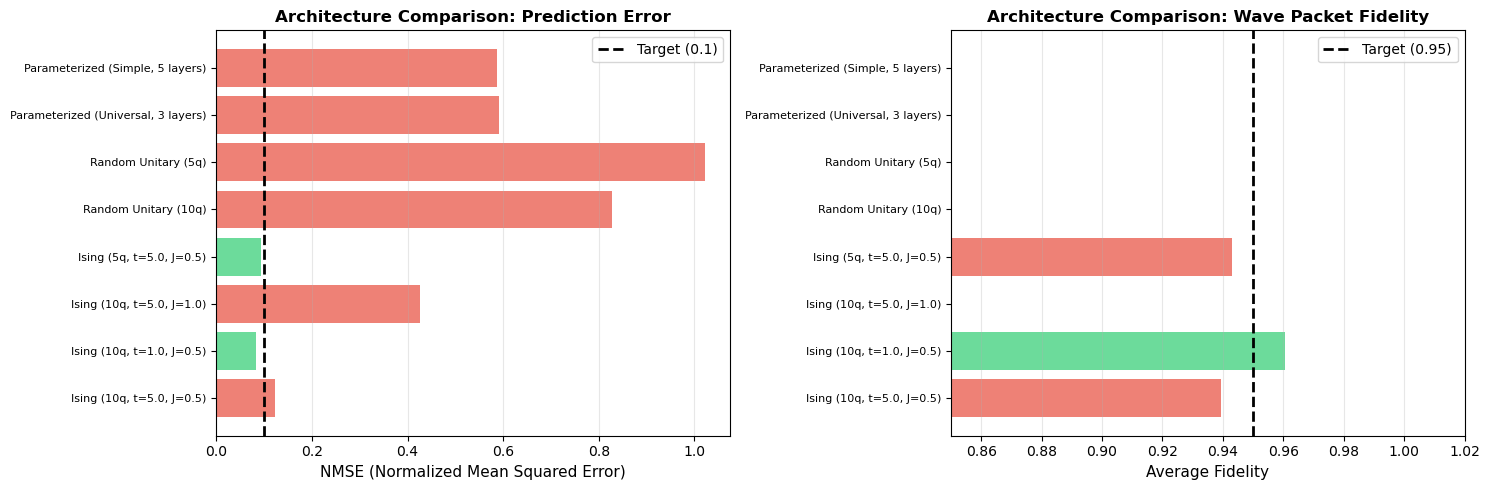

In [15]:
# Plot 1: Architecture Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arch_names = list(results_arch.keys())
nmses = [results_arch[name]['metrics']['nmse'] for name in arch_names]
fidelities = [results_arch[name]['metrics']['avg_fidelity'] for name in arch_names]

# NMSE comparison
ax = axes[0]
colors = ['#2ecc71' if x < 0.1 else '#e74c3c' for x in nmses]
bars = ax.barh(range(len(arch_names)), nmses, color=colors, alpha=0.7)
ax.axvline(0.1, color='black', linestyle='--', linewidth=2, label='Target (0.1)')
ax.set_yticks(range(len(arch_names)))
ax.set_yticklabels(arch_names, fontsize=8)
ax.set_xlabel('NMSE (Normalized Mean Squared Error)', fontsize=11)
ax.set_title('Architecture Comparison: Prediction Error', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Fidelity comparison
ax = axes[1]
colors = ['#2ecc71' if x > 0.95 else '#e74c3c' for x in fidelities]
bars = ax.barh(range(len(arch_names)), fidelities, color=colors, alpha=0.7)
ax.axvline(0.95, color='black', linestyle='--', linewidth=2, label='Target (0.95)')
ax.set_yticks(range(len(arch_names)))
ax.set_yticklabels(arch_names, fontsize=8)
ax.set_xlabel('Average Fidelity', fontsize=11)
ax.set_title('Architecture Comparison: Wave Packet Fidelity', fontsize=12, fontweight='bold')
ax.set_xlim(0.85, 1.02)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('architecture_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved: architecture_comparison.png")
plt.show()

✓ Saved: ablation_studies.png


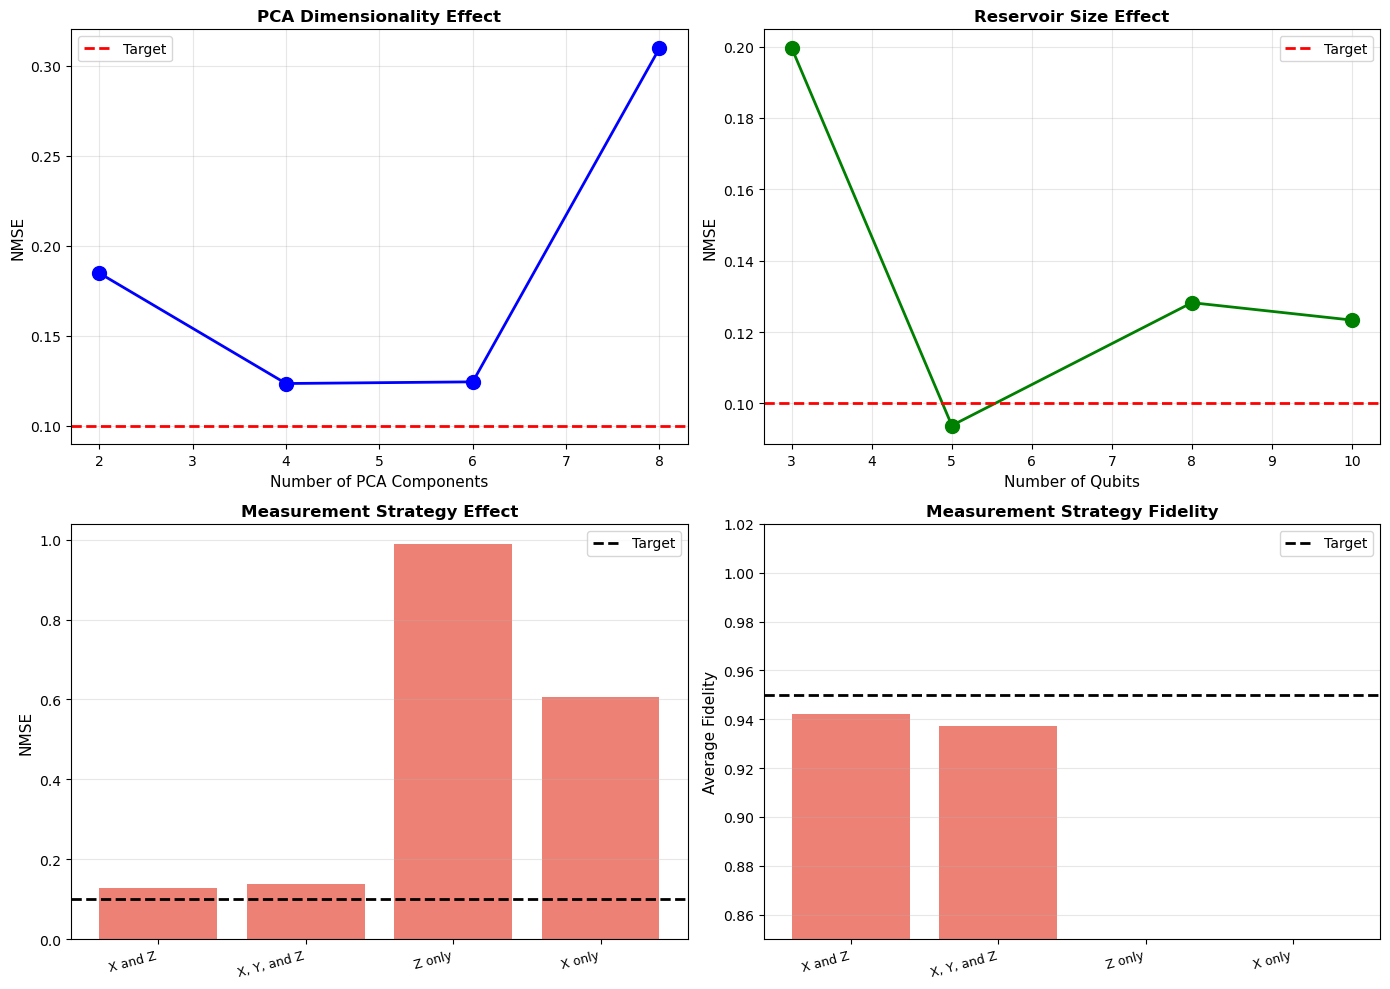

In [16]:
# Plot 2: Ablation Studies
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PCA Components
ax = axes[0, 0]
pca_lens = list(results_pca.keys())
nmses_pca = [results_pca[w]['nmse'] for w in pca_lens]
ax.plot(pca_lens, nmses_pca, 'bo-', linewidth=2, markersize=10)
ax.axhline(0.1, color='r', linestyle='--', linewidth=2, label='Target')
ax.set_xlabel('Number of PCA Components', fontsize=11)
ax.set_ylabel('NMSE', fontsize=11)
ax.set_title('PCA Dimensionality Effect', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Reservoir Size
ax = axes[0, 1]
sizes = list(results_size.keys())
nmses_size = [results_size[s]['nmse'] for s in sizes]
ax.plot(sizes, nmses_size, 'go-', linewidth=2, markersize=10)
ax.axhline(0.1, color='r', linestyle='--', linewidth=2, label='Target')
ax.set_xlabel('Number of Qubits', fontsize=11)
ax.set_ylabel('NMSE', fontsize=11)
ax.set_title('Reservoir Size Effect', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Measurement Strategy (NMSE)
ax = axes[1, 0]
meas_names = list(results_measurement.keys())
nmses_meas = [results_measurement[m]['nmse'] for m in meas_names]
colors = ['#2ecc71' if x < 0.1 else '#e74c3c' for x in nmses_meas]
ax.bar(range(len(meas_names)), nmses_meas, color=colors, alpha=0.7)
ax.axhline(0.1, color='black', linestyle='--', linewidth=2, label='Target')
ax.set_xticks(range(len(meas_names)))
ax.set_xticklabels(meas_names, rotation=15, ha='right', fontsize=9)
ax.set_ylabel('NMSE', fontsize=11)
ax.set_title('Measurement Strategy Effect', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Measurement Strategy (Fidelity)
ax = axes[1, 1]
fids_meas = [results_measurement[m]['avg_fidelity'] for m in meas_names]
colors = ['#2ecc71' if x > 0.95 else '#e74c3c' for x in fids_meas]
ax.bar(range(len(meas_names)), fids_meas, color=colors, alpha=0.7)
ax.axhline(0.95, color='black', linestyle='--', linewidth=2, label='Target')
ax.set_xticks(range(len(meas_names)))
ax.set_xticklabels(meas_names, rotation=15, ha='right', fontsize=9)
ax.set_ylabel('Average Fidelity', fontsize=11)
ax.set_title('Measurement Strategy Fidelity', fontsize=12, fontweight='bold')
ax.set_ylim(0.85, 1.02)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.savefig('ablation_studies.png', dpi=150, bbox_inches='tight')
print("✓ Saved: ablation_studies.png")
plt.show()

✓ Saved: best_model_analysis.png


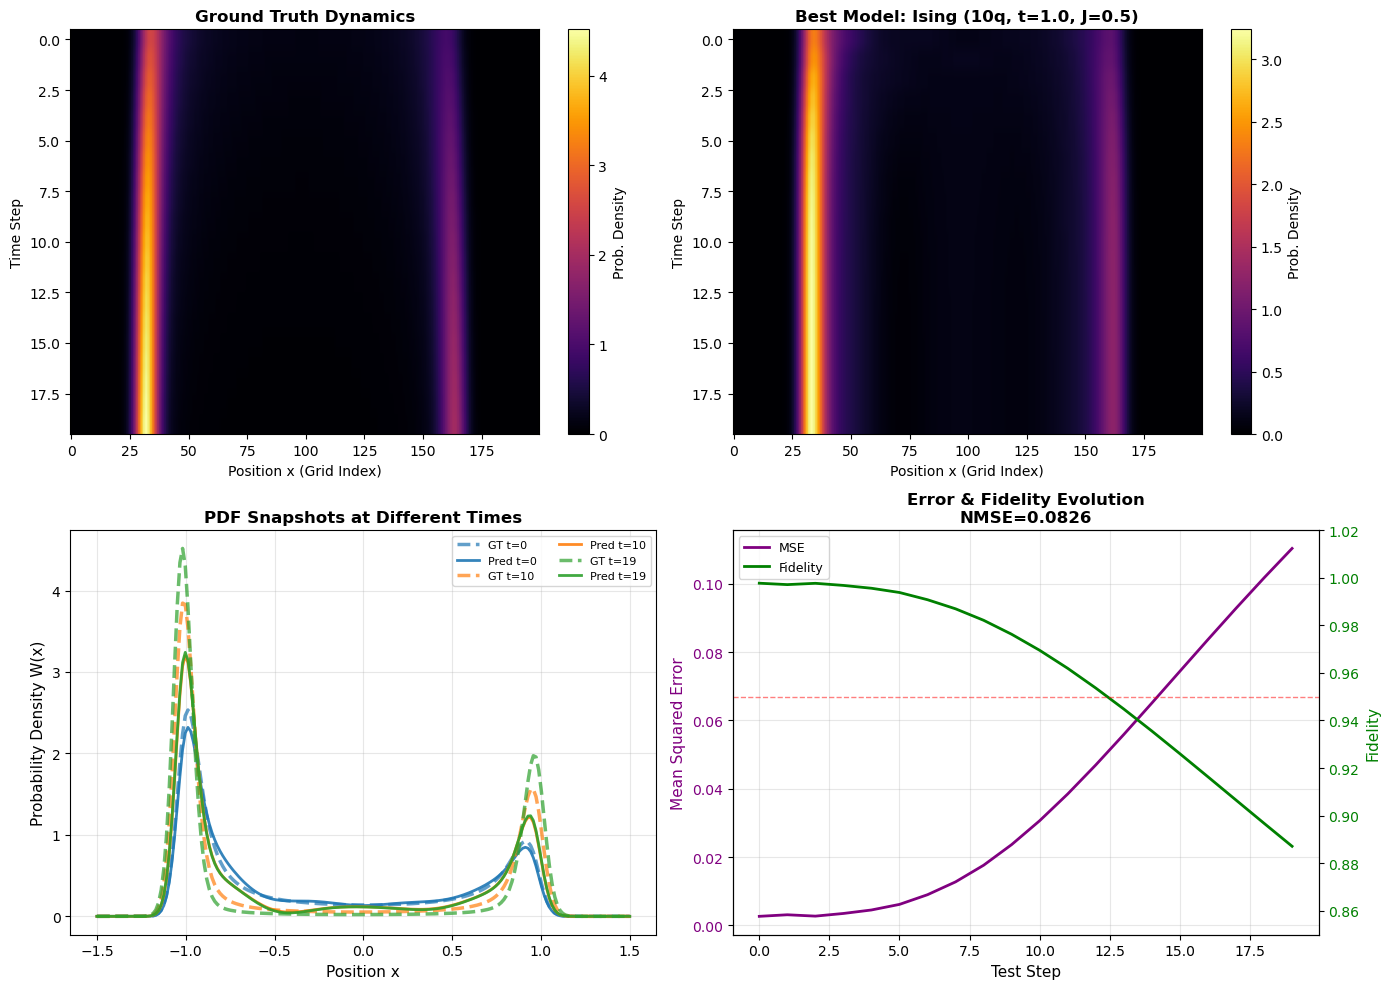

In [17]:
# Plot 3: Best Model Detailed Analysis
best_arch_name = min(results_arch.keys(), key=lambda k: results_arch[k]['metrics']['nmse'])
best_result = results_arch[best_arch_name]
best_pred = best_result['predictions']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Heatmaps
ax = axes[0, 0]
im = ax.imshow(Y_test_gt, aspect='auto', cmap='inferno', origin='upper')
ax.set_title(f'Ground Truth Dynamics', fontsize=12, fontweight='bold')
ax.set_xlabel('Position x (Grid Index)')
ax.set_ylabel('Time Step')
plt.colorbar(im, ax=ax, label='Prob. Density')

ax = axes[0, 1]
im = ax.imshow(best_pred, aspect='auto', cmap='inferno', origin='upper')
ax.set_title(f'Best Model: {best_arch_name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Position x (Grid Index)')
ax.set_ylabel('Time Step')
plt.colorbar(im, ax=ax, label='Prob. Density')

# PDF Cross-sections
ax = axes[1, 0]
x_vals = np.linspace(-1.5, 1.5, data_full.shape[1])
indices = [0, len(best_pred)//2, len(best_pred)-1]
colors_cs = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, idx in enumerate(indices):
    ax.plot(x_vals, Y_test_gt[idx], linestyle='--', linewidth=2.5, 
            color=colors_cs[i], alpha=0.7, label=f'GT t={idx}')
    ax.plot(x_vals, best_pred[idx], linewidth=2, color=colors_cs[i], alpha=0.9, label=f'Pred t={idx}')
ax.set_xlabel('Position x', fontsize=11)
ax.set_ylabel('Probability Density W(x)', fontsize=11)
ax.set_title('PDF Snapshots at Different Times', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Error and Fidelity Evolution
ax = axes[1, 1]
ax2 = ax.twinx()
mse_over_time = np.mean((best_pred - Y_test_gt)**2, axis=1)
fid_over_time = best_result['metrics']['fidelities']

line1 = ax.plot(mse_over_time, color='purple', linewidth=2, label='MSE')
ax.set_xlabel('Test Step', fontsize=11)
ax.set_ylabel('Mean Squared Error', fontsize=11, color='purple')
ax.tick_params(axis='y', labelcolor='purple')
ax.grid(True, alpha=0.3)

line2 = ax2.plot(fid_over_time, color='green', linewidth=2, label='Fidelity')
ax2.axhline(0.95, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Fidelity', fontsize=11, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0.85, 1.02)

ax.set_title(f'Error & Fidelity Evolution\nNMSE={best_result["metrics"]["nmse"]:.4f}', 
             fontsize=12, fontweight='bold')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('best_model_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved: best_model_analysis.png")
plt.show()
